# FWI of the 2D acoustic Marmousi 2 model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion

MARMOUSI_PATH = 'Marmousi2_elastic.npz'

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Helper functions

In [2]:
def plot_model(model,
               sampling=(5,5),
               pclip=99,
               figsize=(15,5),
               cmap='jet',
               title=None,
               xlabel='x pos (m)',
               zlabel='z pos (m)',
               cbar=False,
               cbar_label='$v_p$ (m/s)',
               src_locations=None,
               rec_locations=None):
    fig, ax = plt.subplots(figsize=figsize)
    
    x_axis = sampling[0] * np.arange(model.shape[0])
    z_axis = sampling[1] * np.arange(model.shape[1])

    clip = np.percentile(model,pclip)
    pc = plt.pcolormesh(x_axis,
                  z_axis,
                  model.T,
                  shading='nearest',
                  vmin=0,
                  vmax=clip,
                  cmap=cmap)
    
    plt.gca().invert_yaxis()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(zlabel)
    
    ax.set_title(title)
    
    if cbar:
        cbar = plt.colorbar(pc)
        cbar.set_label(cbar_label)

    if rec_locations is not None:
        plt.scatter(rec_locations[:,0],rec_locations[:,1],marker='v',s=10,c='k',label='rec pos')
        _ = plt.xlim([0,sampling[0]*(model.shape[0]-1)])
        plt.legend()
        
    if src_locations is not None:
        plt.scatter(src_locations[:,0],src_locations[:,1],marker='*',s=10,c='r',label='src pos')
        _ = plt.xlim([0,sampling[0]*(model.shape[0]-1)])
        plt.legend()
        
def plot_wavelet(wavelet,d_t,title='wavelet', figsize=(10,2.5)):
    wavelet_fft = np.fft.rfft(wavelet)
    freqs = np.fft.rfftfreq(len(wavelet),d_t)
    t = d_t * np.arange(len(wavelet))

    fig, axs = plt.subplots(1,2,figsize=figsize)
    
    axs[0].plot(t,wavelet)
    axs[0].set_xlabel('time (s)')
    axs[0].set_title(title)
    
    axs[1].plot(freqs,np.abs(wavelet_fft))
    axs[1].set_xlabel('freq (1/s)')
    axs[1].set_title(f'{title} FFT')
    
def plot_data(data,
              d_t,
              src_locations=None,
              rec_locations=None,
              n_shots=6,
              title='wavelet', 
              figsize=(3,5),
              pclip=99,
              clip=None,
              cmap='gray',
              ylabel='time (s)',
              xlabel='rec positions (m)'):
    fig, axs = plt.subplots(1,n_shots,figsize=(figsize[0]*n_shots,figsize[1]))
    
    skip = data.shape[0]//n_shots
    data = data[::skip]
    if src_locations is not None:
        src_locations = src_locations[::skip,0]
    if rec_locations is None:
        rec_locations = np.arange(data.shape[1])
        xlabel='rec #'
        
    t_axis = d_t * np.arange(data.shape[-1])
    
    if clip is None:
        clip = np.percentile(np.abs(data),pclip)
    for i, (ax,shot) in enumerate(zip(axs,data)):
        ax.pcolormesh(rec_locations[:,0],
                  t_axis,
                  shot.T,
                  shading='nearest',
                  vmin=-clip,
                  vmax=clip,
                  cmap=cmap)
        ax.invert_yaxis()
        if src_locations is None:
            ax.set_title(f'shot# {i*skip}')
        else:
            ax.set_title(f'shot pos %.2f' % src_locations[i])
            
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

## Load and plot marmousi 

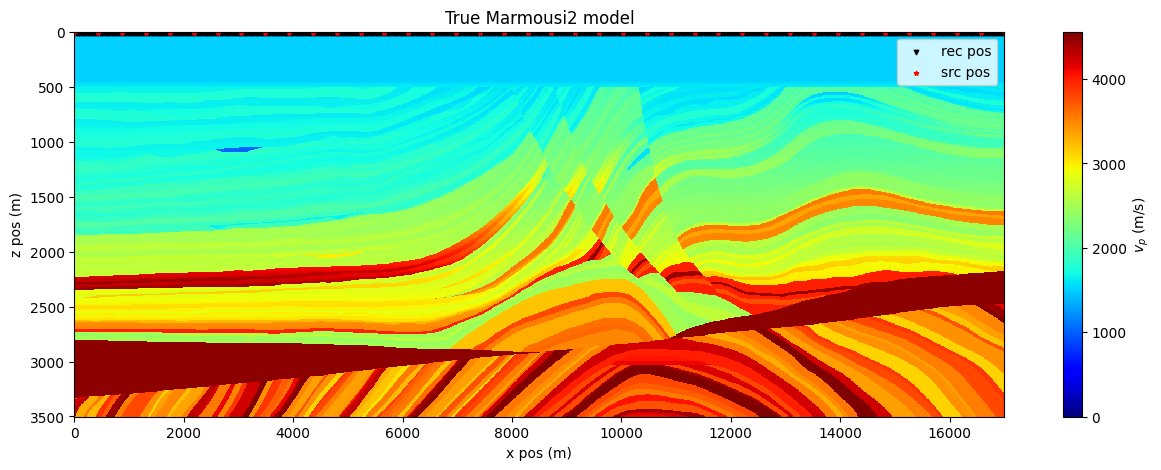

In [3]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 40
x_src = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_src)
z_src = 10.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation solver

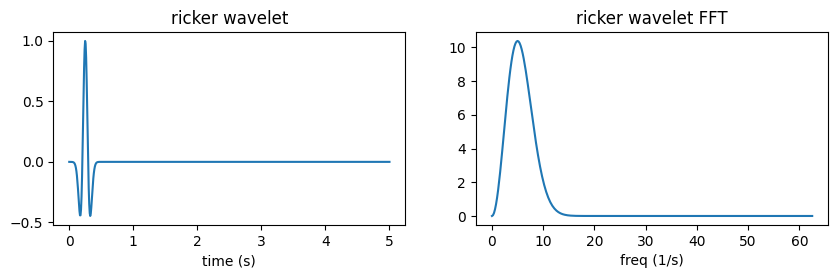

In [4]:
# make a Ricker wavelet
n_t = 626
d_t = 0.008
dom_freq = 5.0
delay = 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plot_wavelet(ricker,d_t,title='ricker wavelet')

In [5]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(50, 50),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3])

## Make observed data

CPU times: user 1min 6s, sys: 27.8 s, total: 1min 34s
Wall time: 16.9 s


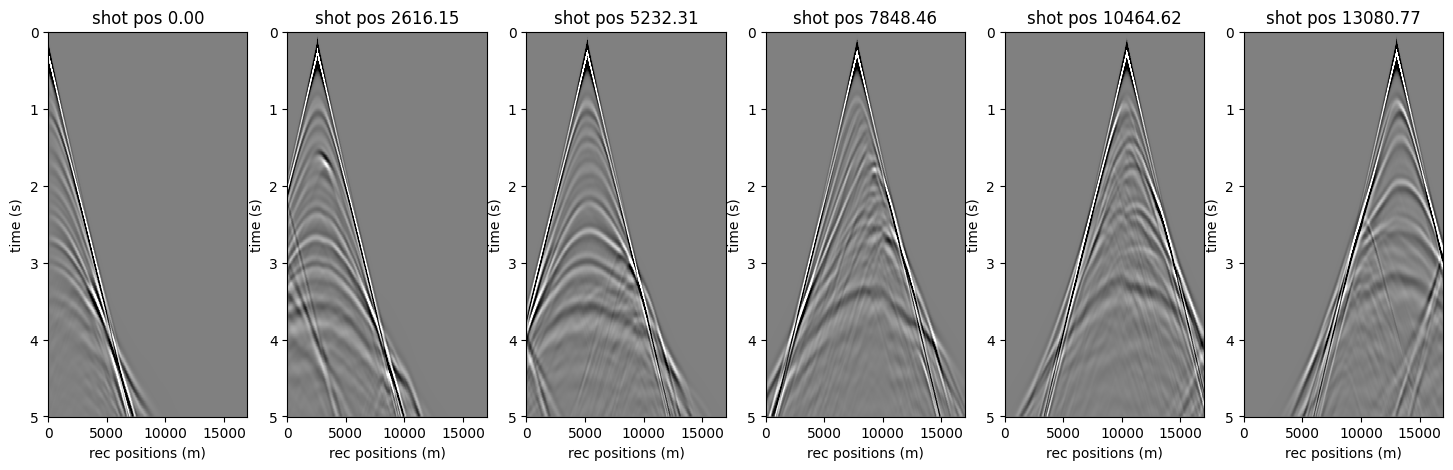

In [6]:
%%time
data_obs = acoustic_2d.forward(true_model)

plot_data(data_obs,
          d_t,
          src_locations=srcs,
          rec_locations=recs)

## Make starting model

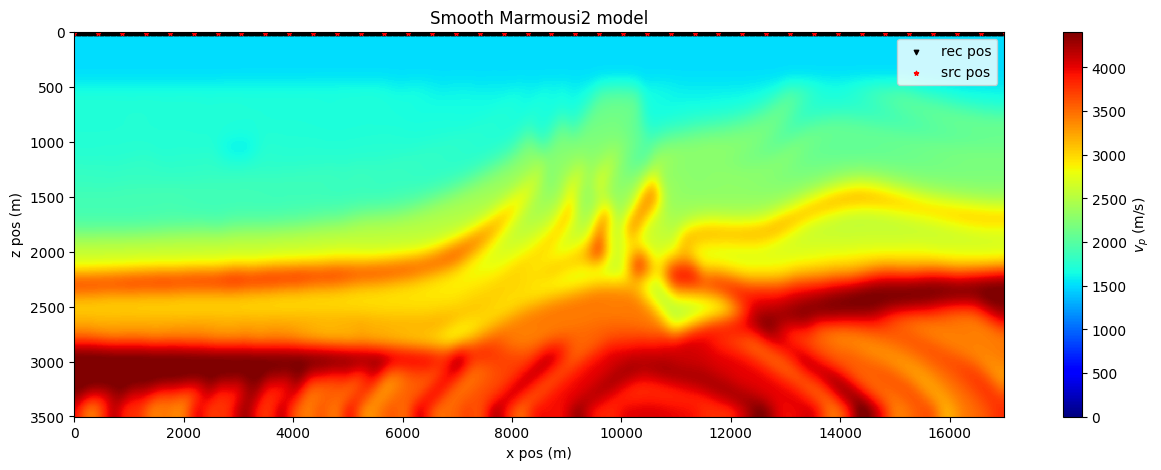

In [7]:
starting_model = ndimage.gaussian_filter(true_model,(20,20))

plot_model(starting_model,
           title='Smooth Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## FWI template

In [8]:
fwi_prob = inversion.Fwi(acoustic_2d,
                         data_obs,
                         starting_model,
                         num_iter=20,
                         iterations_per_save=5)

In [ ]:
%%time

history = fwi_prob.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2023-01-12T01-40-46.788443/
##########################################################################################

iter = 00, obj = 8.13570e+04, resnorm = 4.03e+02, gradnorm = 7.37e+00, feval = 1, geval = 1
iter = 01, obj = 4.36251e+04, resnorm = 2.95e+02, gradnorm = 2.37e+00, feval = 4, geval = 2
iter = 02, obj = 3.41258e+04, resnorm = 2.61e+02, gradnorm = 1.91e+00, feval = 7, geval = 3
iter = 03, obj = 2.73146e+04, resnorm = 2.34e+02, gradnorm = 1.61e+00, feval = 10, geval = 4
iter = 04, obj = 2.42473e+04, resnorm = 2.20e+02, gradnorm = 1.09e+00, feval = 13, geval = 5
iter = 05, obj = 2.17132e+04, resnorm = 2.08e+02, gradnorm = 9.29e-01, feval = 16, geval = 6
iter = 06, obj = 2.00604e+04, resnorm = 2.00e+02, gradnorm = 8.61e-01, feval = 19, geval = 7


In [ ]:
history.keys()

## Plot objective function as a function of iteration

In [ ]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

## Plot final model

In [ ]:
plot_model(history['inv_mod'],
           title='Final inverted model', 
           cbar=True)

plot_model(history['inv_mod']-starting_model,
           title='Inverted model minus strating model', 
           cbar=True,
          pclip=100)

## Plot first and last residual

In [ ]:
clip = np.percentile(data_obs,99)

plot_data(history['residual'][0],
          d_t,
          src_locations=srcs,
          rec_locations=recs,
          clip=clip)

plot_data(history['residual'][-1],
          d_t,
          src_locations=srcs,
          rec_locations=recs,
          clip=clip)